In [1]:
from astrometry import astrometry

In [2]:
astro = astrometry("C:/Users/truji/Desktop/MIT_F25/12_411/data/20260109/", 
                   "/mnt/c/Users/truji/Desktop/MIT_F25/12_411/data/20260109/", "O20260109_1034.fits")

In [3]:
astro.get_solutions(xyls=True)
astro.make_poly()

Identifying Sources: 100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


Tracking:   0%|          | 0/1 [00:00<?, ?it/s]

plot requesting
plotting now!!!!!!!!!!!


Tracking: 100%|██████████| 1/1 [00:09<00:00,  9.37s/it]

plot made?
{'Herberta': [(np.float64(28.335090217392047), np.float64(27.599363569922055))]}


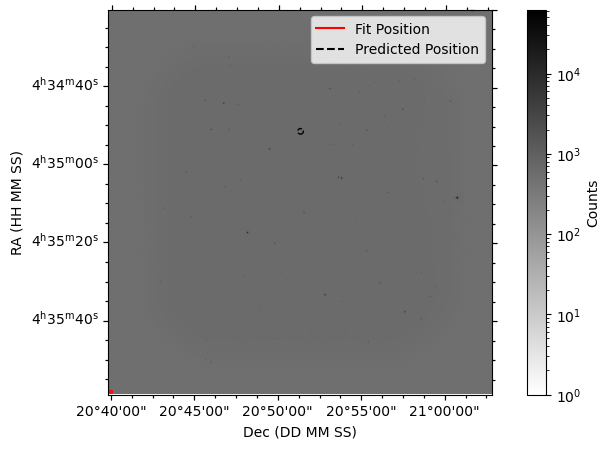

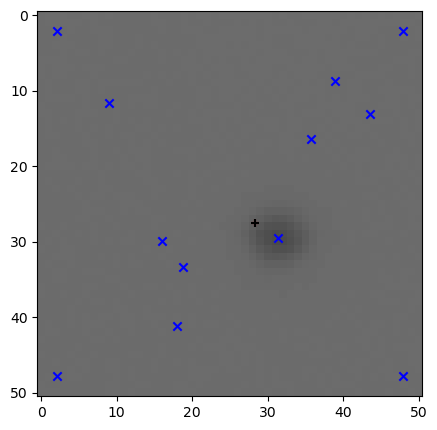

In [4]:
print(astro.track_objects(["Herberta"], make_plots=True))